In [1]:
# imports

import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# data transformation

# 1. Convert to Tensor
# 2. Normalize. First sequence is the mean and the second is the standard dev. Each number is for each channel (RGB)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# download the train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# batch loader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# batch loader
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 deer  ship  frog  frog


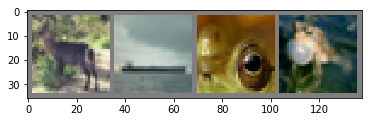

In [4]:
# display some of the training images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
# define a convolution network
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # view basically reshapes the tensor
        # row = -1 means idk how many rows i'll have but
        # give me the appropriate # of rows given the # of columns
        # we need to do this b/c at this point we have a 2D, 16-feature map
        # from the convolution layer, and in order to pass this into
        # a fully connected layer, we need to flatten it.
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
# define a loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

# the tutorial uses SGD, but let's try Adam
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())

In [8]:
# Train!

for epoch in range(2):  # loop over the dataset multiple times, twice in this case

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):   # trainloader produces batches
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.859
[1,  4000] loss: 1.595
[1,  6000] loss: 1.517
[1,  8000] loss: 1.461
[1, 10000] loss: 1.409
[1, 12000] loss: 1.388
[2,  2000] loss: 1.317
[2,  4000] loss: 1.282
[2,  6000] loss: 1.314
[2,  8000] loss: 1.267
[2, 10000] loss: 1.265
[2, 12000] loss: 1.265
Finished Training


GroundTruth:    cat  ship  ship plane


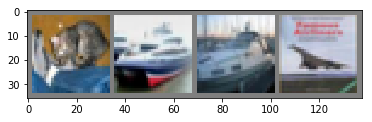

In [9]:
# now let's test!
# but first let's print out some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
# how would our neural net do?
outputs = net(Variable(images))   # turn images into Variable and feed forward to the network
# each row represents each image, each column represents each class. each cell is therefore 
# the probability of each image belonging to each class
print(outputs.data)  
# now we pick the max value over row (dimension 1), if we used dimension 0, it would've done it over column
# the first return value is the max probability
# the second return value is the position of the max value (argmax)
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


-3.1437 -3.9435 -0.0868  1.2787  0.8450  0.9226 -0.1606 -0.0363 -4.0076 -3.0533
-4.6190 -6.2312 -0.0805  0.8710 -2.1788  2.4443 -3.7288  1.4382 -5.9817 -4.0337
 0.0656  0.6428 -1.6833 -2.0288 -0.3429 -2.7741 -1.6774 -1.8343 -1.3220  0.0450
-4.5454 -4.7148 -2.8367 -3.6745  1.6497 -2.3606 -3.1725  4.0073 -7.1755 -4.5480
[torch.FloatTensor of size 4x10]

Predicted:    cat   dog   car horse


In [11]:
# how about on the whole dataset?

correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %
